In [31]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

In [3]:
file_path = 'C:\\Users\\Asus\\Downloads\\housePrice.csv'
data = pd.read_csv(file_path)


In [4]:
print(data.head()) # نمایش چند ردیف اول از داده
print(data.info())  #نمایش اطلاعات کلی درباره ستون‌ها و نوع داده


  Area  Room  Parking  Warehouse  Elevator         Address         Price  \
0   63     1     True       True      True         Shahran  1.850000e+09   
1   60     1     True       True      True         Shahran  1.850000e+09   
2   79     2     True       True      True          Pardis  5.500000e+08   
3   95     2     True       True      True   Shahrake Qods  9.025000e+08   
4  123     2     True       True      True  Shahrake Gharb  7.000000e+09   

   Price(USD)  
0    61666.67  
1    61666.67  
2    18333.33  
3    30083.33  
4   233333.33  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price   

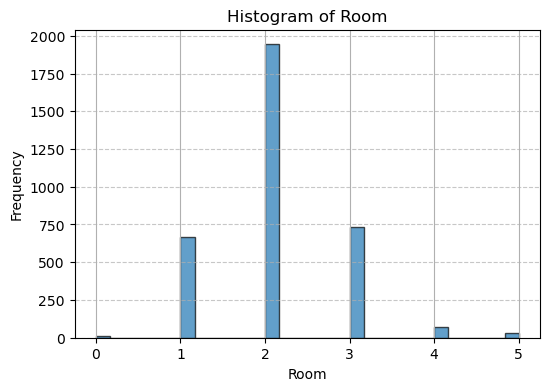

Outliers in Room:
0       1
1       1
7       1
9       1
11      1
       ..
3461    1
3462    1
3463    3
3472    3
3473    1
Name: Room, Length: 1513, dtype: int64



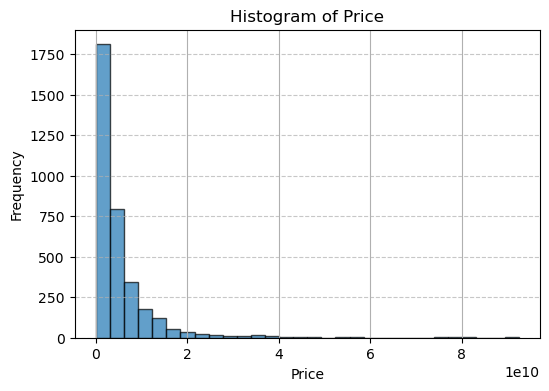

Outliers in Price:
25      1.494500e+10
102     1.690000e+10
146     2.000000e+10
160     2.695000e+10
161     2.430000e+10
            ...     
3366    1.556300e+10
3373    1.300000e+10
3394    2.250000e+10
3438    1.500000e+10
3442    1.400000e+10
Name: Price, Length: 310, dtype: float64



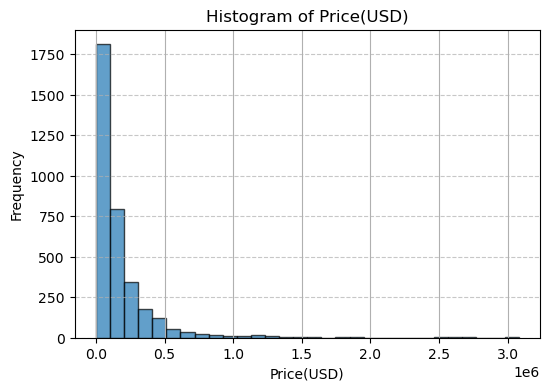

Outliers in Price(USD):
25      498166.67
102     563333.33
146     666666.67
160     898333.33
161     810000.00
          ...    
3366    518766.67
3373    433333.33
3394    750000.00
3438    500000.00
3442    466666.67
Name: Price(USD), Length: 310, dtype: float64



In [7]:
# Step 2: Clean the dataset
# Remove rows with missing addresses and create a copy
data_cleaned = data.dropna(subset=['Address']).copy()

# Convert 'Area' to numeric, and remove invalid or extreme values
data_cleaned.loc[:, 'Area'] = pd.to_numeric(data_cleaned['Area'], errors='coerce')
data_cleaned = data_cleaned.dropna(subset=['Area'])
data_cleaned = data_cleaned[data_cleaned['Area'] < 1000]

# Convert boolean columns to integers
boolean_columns = ['Parking', 'Warehouse', 'Elevator']
data_cleaned.loc[:, boolean_columns] = data_cleaned[boolean_columns].astype(int)

# Handle missing data (if any)
data = data.dropna()  # Drop rows with missing values

# Function to detect outliers using IQR
def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Analyze numerical columns
for column in data.select_dtypes(include=['int64', 'float64']).columns:
    # Plot histogram
    plt.figure(figsize=(6, 4))
    data[column].hist(bins=30, edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Detect outliers
    outliers = detect_outliers(data[column])
    print(f"Outliers in {column}:\n{outliers}\n")

# Save the clean dataset (optional)
data.to_csv('cleaned_data.csv', index=False)


In [11]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
address_encoded = encoder.fit_transform(data_cleaned[['Address']])
address_encoded_df = pd.DataFrame(address_encoded, columns=encoder.get_feature_names_out(['Address']))


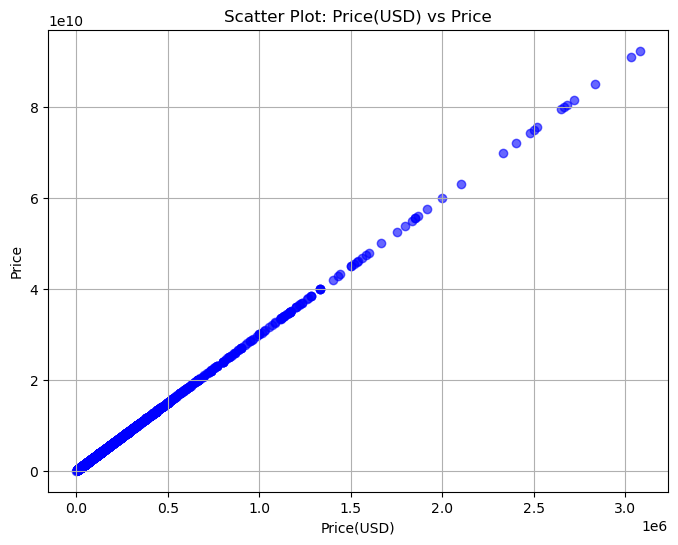

In [12]:
# Check if the required columns exist before plotting
if 'Price(USD)' in data.columns and 'Price' in data.columns:
    # Plot the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(data['Price(USD)'], data['Price'], color='blue', alpha=0.6)
    plt.xlabel("Price(USD)")
    plt.ylabel("Price")
    plt.title("Scatter Plot: Price(USD) vs Price")
    plt.grid(True)
    plt.show()
else:
    print("The required columns 'Price(USD)' and 'Price' are not present in the dataset.")


In [15]:
# Randomly split the data into training and testing sets (80-20 split)
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

# Display the shape of the training and testing sets
print(f"Training set shape: {train.shape}")
print(f"Testing set shape: {test.shape}")

# Save the splits (optional)
train.to_csv('train_data.csv', index=False)
test.to_csv('test_data.csv', index=False)


Training set shape: (2760, 8)
Testing set shape: (696, 8)


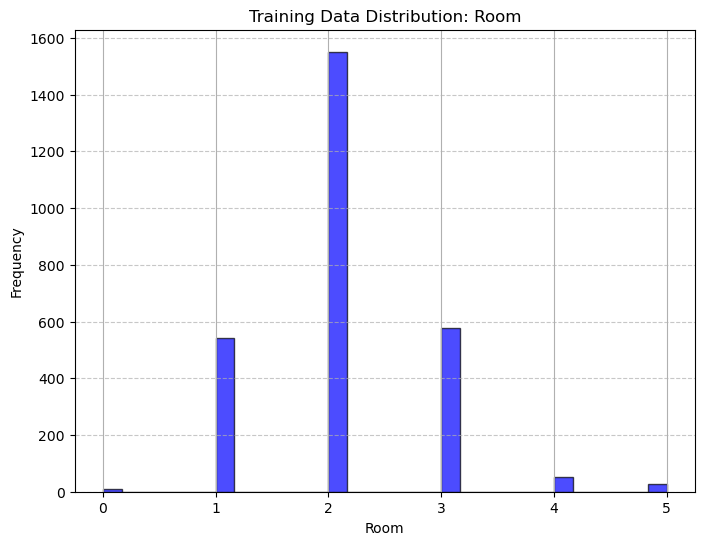

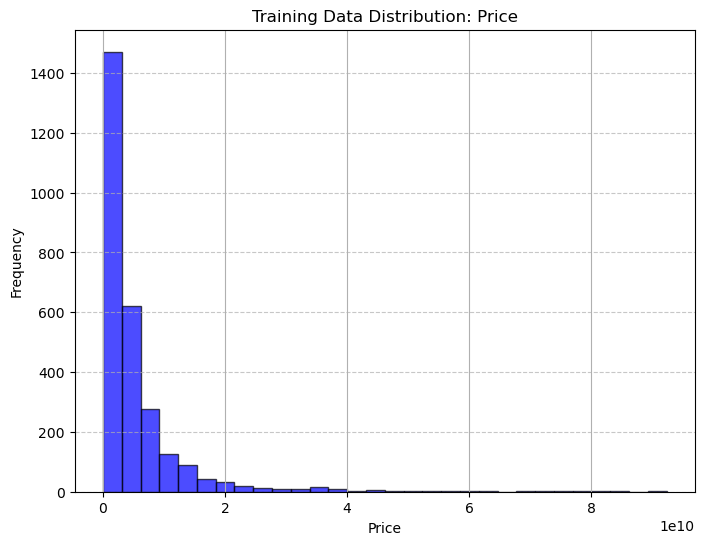

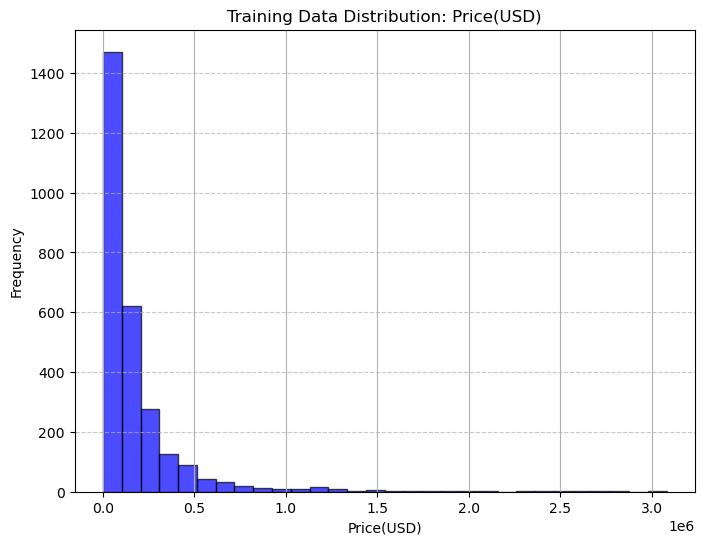

In [16]:
# Analyze the distribution of training data
for column in train.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(8, 6))
    train[column].hist(bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.title(f"Training Data Distribution: {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [18]:
# Ensure that 'Area' is present and encoded properly
if 'Area' in data.columns:
    # Check if 'Area' is categorical and needs encoding
    if data['Area'].dtype == 'object':
        # One-hot encode 'Area'
        encoded_data = pd.get_dummies(data, columns=['Area'], drop_first=True)
    else:
        encoded_data = data.copy()
else:
    print("The column 'Area' is not found in the dataset. Please check the data.")

# Ensure 'Address' is encoded
if 'Address' in data.columns and data['Address'].dtype == 'object':
    encoded_data = pd.get_dummies(encoded_data, columns=['Address'], drop_first=True)

# Define features and target
features = list(encoded_data.columns.difference(['Price', 'Price(USD)']))
target = 'Price(USD)'  # Change to 'Price' for prediction in Toman

# Define X (features) and y (target)
X = encoded_data[features]
y = encoded_data[target]

# Display the first few rows
print("Encoded Features (X):")
print(X.head())

print("\nTarget (y):")
print(y.head())


Encoded Features (X):
   Address_Abbasabad  Address_Absard  Address_Abuzar  Address_Afsarieh  \
0              False           False           False             False   
1              False           False           False             False   
2              False           False           False             False   
3              False           False           False             False   
4              False           False           False             False   

   Address_Ahang  Address_Air force  Address_Ajudaniye  \
0          False              False              False   
1          False              False              False   
2          False              False              False   
3          False              False              False   
4          False              False              False   

   Address_Alborz Complex  Address_Aliabad South  Address_Amir Bahador  ...  \
0                   False                  False                 False  ...   
1                   False 

In [20]:
# Step 4: Standardize numerical features
# Initialize the scaler
scaler = StandardScaler()

# Ensure 'Area', 'Room', 'Parking', 'Warehouse', 'Elevator' are part of X
numerical_features = ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator']
numerical_features = [feature for feature in numerical_features if feature in X.columns]

# Standardize the selected numerical features
X.loc[:, numerical_features] = scaler.fit_transform(X[numerical_features])

# Display a sample of the standardized features
print("Standardized Features:")
print(X[numerical_features].head())


Standardized Features:
       Room   Parking  Warehouse  Elevator
0 -1.423499  0.424176   0.304925  0.519732
1 -1.423499  0.424176   0.304925  0.519732
2 -0.107039  0.424176   0.304925  0.519732
3 -0.107039  0.424176   0.304925  0.519732
4 -0.107039  0.424176   0.304925  0.519732


In [23]:
# Step 5: Split the dataset into training and testing sets# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the resulting datasets
print("Training Set:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print("\nTesting Set:")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Training Set:
X_train shape: (2764, 437)
y_train shape: (2764,)

Testing Set:
X_test shape: (692, 437)
y_test shape: (692,)


In [24]:
# Step 6: Train a Linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Train the model on the training data
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Linear Regression Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")


Linear Regression Model Evaluation:
Mean Squared Error (MSE): 3.0025731872217748e+32
R-squared (R²): -3.374472076634761e+21


In [32]:
#Evaluation
# Predict on the test set using the trained model
test_x = np.asanyarray(X_test[['Room', 'Parking', 'Warehouse', 'Elevator']])
test_y = np.asanyarray(y_test).reshape(-1, 1)
test_y_pred = regr.predict(test_x)

# Calculate evaluation metrics
mae = mean_absolute_error(test_y, test_y_pred)
mse = mean_squared_error(test_y, test_y_pred)
r2 = r2_score(test_y, test_y_pred)

# Print the evaluation metrics
print("Mean absolute error (MAE): %.2f" % mae)
print("Residual sum of squares (MSE): %.2f" % mse)
print("R2-score: %.2f" % r2)


Mean absolute error (MAE): 136357.85
Residual sum of squares (MSE): 58324685912.68
R2-score: 0.34


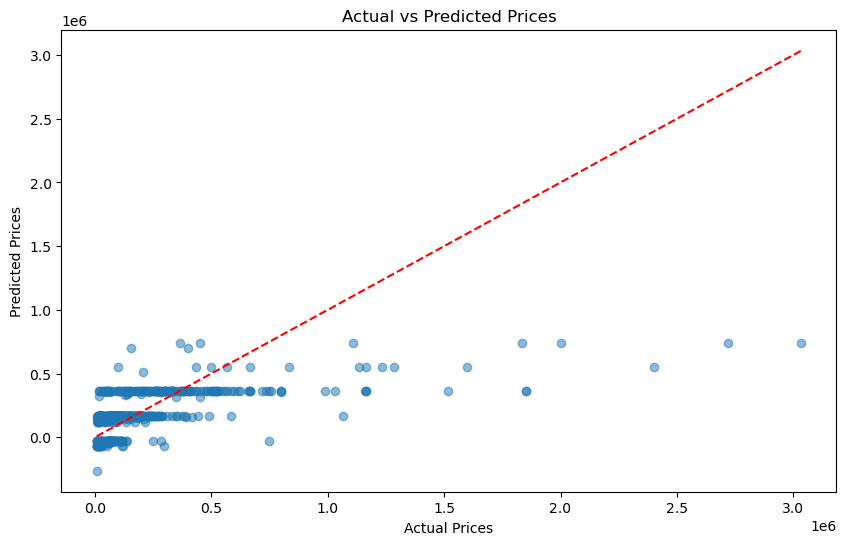

In [33]:

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()
